In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Computed Mean: 0.0004776278268837927, Std: 0.04881019355961118
Data Augmented
Model Created
Epoch 1, Loss: 0.6528
Epoch 2, Loss: 0.5816
Epoch 3, Loss: 0.5691
Epoch 4, Loss: 0.5635
Epoch 5, Loss: 0.5599
Epoch 6, Loss: 0.5572
Epoch 7, Loss: 0.5549
Epoch 8, Loss: 0.5530
Epoch 9, Loss: 0.5517
Epoch 10, Loss: 0.5503
Epoch 11, Loss: 0.5494
Epoch 12, Loss: 0.5483
Epoch 13, Loss: 0.5475
Epoch 14, Loss: 0.5467
Epoch 15, Loss: 0.5457
Epoch 16, Loss: 0.5452
Epoch 17, Loss: 0.5443
Epoch 18, Loss: 0.5432
Epoch 19, Loss: 0.5426
Epoch 20, Loss: 0.5420
Epoch 21, Loss: 0.5412
Epoch 22, Loss: 0.5410
Epoch 23, Loss: 0.5405
Epoch 24, Loss: 0.5396
Epoch 25, Loss: 0.5395
Epoch 26, Loss: 0.5385
Epoch 27, Loss: 0.5384
Epoch 28, Loss: 0.5379
Epoch 29, Loss: 0.5372
Epoch 30, Loss: 0.5370
Training Finished


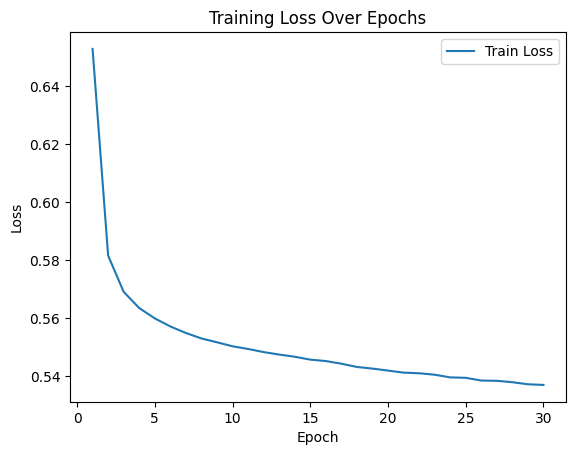

Accuracy: 72.79%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import h5py
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

# Custom Dataset Class
class ParticleDataset(Dataset):
    def __init__(self, hdf5_files, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        
        for idx, file in enumerate(hdf5_files):
            with h5py.File(file, 'r') as f:
                X = f['X'][:]
                y = np.full((X.shape[0],), idx)  # Assign label 0 for electrons, 1 for photons
                self.data.append(X)
                self.labels.append(y)
        
        self.data = np.concatenate(self.data, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Load Dataset
full_dataset = ParticleDataset(['/kaggle/input/cms-particle-collison/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 
                                '/kaggle/input/cms-particle-collison/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'])

# Split into Train and Test  # **MODIFIED**
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Compute Mean and Std for Normalization on Train Set  # **MODIFIED**
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    mean = 0.0
    std = 0.0
    total_samples = 0
    for images, _ in loader:
        batch_samples = images.size(0)  # Batch size
        images = images.view(batch_samples, -1)
        mean += images.mean(dim=1).sum().item()
        std += images.std(dim=1).sum().item()
        total_samples += batch_samples
    mean /= total_samples
    std /= total_samples
    return mean, std

mean, std = compute_mean_std(train_dataset)  # **MODIFIED**
print(f"Computed Mean: {mean}, Std: {std}")

# Define Data Augmentation and Normalization  # **MODIFIED**
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((mean,), (std,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Reload dataset with transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data Augmented")

# Define ResNet-like Model
class ResNet15(nn.Module):
    def __init__(self):
        super(ResNet15, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.res_layers = self._make_res_layers(64, 128, 4)
        # Compute final feature map size dynamically
        with torch.no_grad():
            dummy_input = torch.randn(1, 2, 32, 32)
            dummy_output = self.res_layers(self.relu(self.bn1(self.conv1(dummy_input))))
            final_h, final_w = dummy_output.shape[2], dummy_output.shape[3]
        
        self.fc = nn.Linear(128 * final_h * final_w, 2)
    
    def _make_res_layers(self, in_channels, out_channels, blocks):
        layers = []
        for _ in range(blocks):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.res_layers(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet15().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

print("Model Created")

# Training Loop
num_epochs = 30
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

print("Training Finished")

# Plot Training Loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


In [3]:
torch.save(model.state_dict(), "resnet15_weights.pth")